In [8]:
import numpy as np
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

IMG_WIDTH = 150
IMG_HEIGHT = 150
batch_size = 32
train_data_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/train"

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    class_mode='binary',  
    subset='training',
    shuffle=False 
)

val_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.


In [11]:
def extract_features(generator):
    features = base_model.predict(generator)
    features = features.reshape(features.shape[0], -1)
    return features, generator.classes

In [12]:
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(val_generator)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 240ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step


RandomForestClassifier(random_state=42)

In [13]:
y_pred = rf.predict(X_test)

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.8412
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       231
           1       0.81      0.84      0.83       191

    accuracy                           0.84       422
   macro avg       0.84      0.84      0.84       422
weighted avg       0.84      0.84      0.84       422



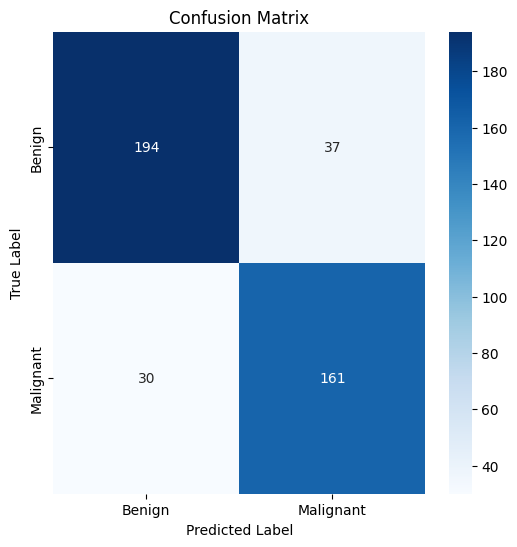

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

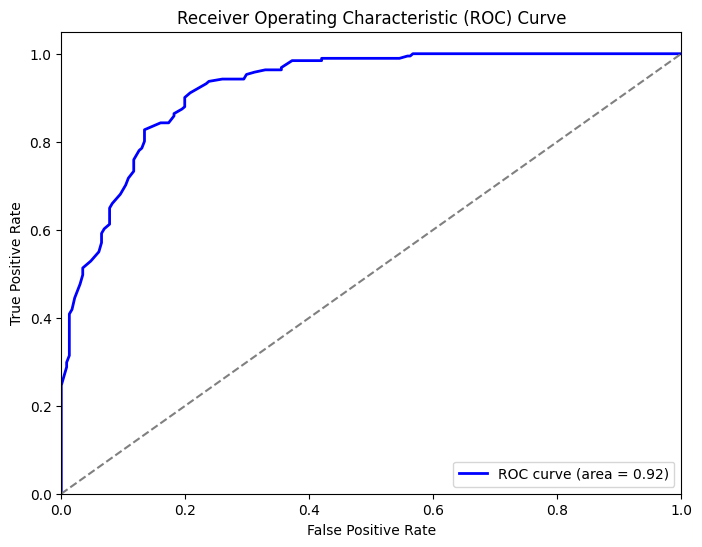

In [16]:
from sklearn.metrics import roc_curve, auc

y_prob = rf.predict_proba(X_test)[:, 1] 

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
